In [1]:
import torch
import numpy as np
from torch import nn
import torchvision
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler

In [77]:
from matplotlib import pyplot as plt

In [2]:
import torch.nn.functional as F

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,),(0.5,)),
                              ])

In [5]:
trainset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True, download=True, transform=transform)

validset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=True, download=True, transform=transform)

testset= datasets.CIFAR10('~/.pytorch/CIFAR10_data/', train=False, download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
num_train = len(trainset)
num_test = len(testset)
indices = list(range(num_train))
split = int(np.floor(0.3 * num_train))

np.random.seed(42)
np.random.shuffle(indices)
batch_size = 100
pin_memory = 1
num_workers = 1

In [7]:
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    num_workers=num_workers, pin_memory=pin_memory,
)
valid_loader = torch.utils.data.DataLoader(
    validset, batch_size=batch_size, sampler=valid_sampler,
    num_workers=num_workers, pin_memory=pin_memory,
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, num_workers=num_workers, 
    pin_memory=pin_memory, shuffle=True
)

In [8]:
for imgs,labels in test_loader:
    print(imgs.shape,labels.shape)
    break

torch.Size([100, 3, 32, 32]) torch.Size([100])


## 1 CNN, 1 BNorm, 1 Dense

In [9]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(10)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [24]:
CNN = CNNModel().to(device)

In [25]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [26]:
epochs = 25
iter_n = 0

In [27]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 1.8129550218582153. Accuracy: 40.0
Iteration: 350. Loss: 1.6908389329910278. Accuracy: 46.0
Epoch 2 of 25
Iteration: 175. Loss: 1.621124267578125. Accuracy: 38.0
Iteration: 350. Loss: 1.4925602674484253. Accuracy: 54.0
Epoch 3 of 25
Iteration: 175. Loss: 1.5048720836639404. Accuracy: 56.0
Iteration: 350. Loss: 1.3437069654464722. Accuracy: 56.0
Epoch 4 of 25
Iteration: 175. Loss: 1.4422128200531006. Accuracy: 59.0
Iteration: 350. Loss: 1.2564700841903687. Accuracy: 60.0
Epoch 5 of 25
Iteration: 175. Loss: 1.4014668464660645. Accuracy: 58.0
Iteration: 350. Loss: 1.2008384466171265. Accuracy: 60.0
Epoch 6 of 25
Iteration: 175. Loss: 1.3690927028656006. Accuracy: 68.0
Iteration: 350. Loss: 1.1595699787139893. Accuracy: 63.0
Epoch 7 of 25
Iteration: 175. Loss: 1.342239499092102. Accuracy: 56.0
Iteration: 350. Loss: 1.1261568069458008. Accuracy: 64.0
Epoch 8 of 25
Iteration: 175. Loss: 1.3209446668624878. Accuracy: 62.0
Iteration: 350. Loss: 1.09929621219

In [28]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 65.56666564941406


In [29]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 65.35800170898438


## 1 CNN, 0 BNorm, 1 Dense

In [30]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [32]:
CNN = CNNModel().to(device)

In [33]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [34]:
epochs = 25
iter_n = 0

In [35]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 2.0499024391174316. Accuracy: 26.0
Iteration: 350. Loss: 1.9542573690414429. Accuracy: 38.0
Epoch 2 of 25
Iteration: 175. Loss: 1.8603862524032593. Accuracy: 43.0
Iteration: 350. Loss: 1.8056813478469849. Accuracy: 34.0
Epoch 3 of 25
Iteration: 175. Loss: 1.7827110290527344. Accuracy: 39.0
Iteration: 350. Loss: 1.7305575609207153. Accuracy: 43.0
Epoch 4 of 25
Iteration: 175. Loss: 1.7349331378936768. Accuracy: 38.0
Iteration: 350. Loss: 1.679904818534851. Accuracy: 40.0
Epoch 5 of 25
Iteration: 175. Loss: 1.7024378776550293. Accuracy: 41.0
Iteration: 350. Loss: 1.6445605754852295. Accuracy: 37.0
Epoch 6 of 25
Iteration: 175. Loss: 1.6790611743927002. Accuracy: 41.0
Iteration: 350. Loss: 1.6185753345489502. Accuracy: 36.0
Epoch 7 of 25
Iteration: 175. Loss: 1.6613181829452515. Accuracy: 40.0
Iteration: 350. Loss: 1.5980857610702515. Accuracy: 53.0
Epoch 8 of 25
Iteration: 175. Loss: 1.6474796533584595. Accuracy: 40.0
Iteration: 350. Loss: 1.5808736085

In [36]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 51.95333480834961


In [37]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 51.4739990234375


## 1 CNN, 1 BNorm, 2 Dense

In [44]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(10)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(10*16*16,64)
        self.dense2 = nn.Linear(64,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = F.relu(self.dense1(out))
        out = self.dense2(out)
#         out = F.softmax(out)
        
        return out
        
        

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [46]:
CNN = CNNModel().to(device)

In [47]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [48]:
epochs = 25
iter_n = 0

In [49]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 2.0165414810180664. Accuracy: 20.0
Iteration: 350. Loss: 1.9329559803009033. Accuracy: 30.0
Epoch 2 of 25
Iteration: 175. Loss: 1.7590495347976685. Accuracy: 42.0
Iteration: 350. Loss: 1.7343573570251465. Accuracy: 40.0
Epoch 3 of 25
Iteration: 175. Loss: 1.6513782739639282. Accuracy: 32.0
Iteration: 350. Loss: 1.638769507408142. Accuracy: 58.0
Epoch 4 of 25
Iteration: 175. Loss: 1.5861330032348633. Accuracy: 46.0
Iteration: 350. Loss: 1.5686743259429932. Accuracy: 44.0
Epoch 5 of 25
Iteration: 175. Loss: 1.5319992303848267. Accuracy: 49.0
Iteration: 350. Loss: 1.5058608055114746. Accuracy: 40.0
Epoch 6 of 25
Iteration: 175. Loss: 1.4852964878082275. Accuracy: 54.0
Iteration: 350. Loss: 1.4450868368148804. Accuracy: 49.0
Epoch 7 of 25
Iteration: 175. Loss: 1.4401849508285522. Accuracy: 60.0
Iteration: 350. Loss: 1.3854775428771973. Accuracy: 47.0
Epoch 8 of 25
Iteration: 175. Loss: 1.3950564861297607. Accuracy: 60.0
Iteration: 350. Loss: 1.3286144733

In [50]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 68.45999908447266


In [51]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 68.47799682617188


## 2 CNN, 1 BNorm, 1 Dense

In [68]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(3,10,kernel_size=3,padding=1)
        self.cnn2 = nn.Conv2d(10,20,kernel_size=3,padding=1)
        self.bnorm1 = nn.BatchNorm2d(20)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dense1 = nn.Linear(20*16*16,10)
    def forward(self,x):
        out = self.cnn1(x)
        out = self.cnn2(out)
        out = self.bnorm1(out)
        out = self.maxpool1(out)
        
        out = out.view(out.shape[0],-1)
        
        out = self.dense1(out)
#         out = F.softmax(out)
        
        return out
        
        

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [70]:
CNN = CNNModel().to(device)

In [71]:
lr = 0.001
optimizer = optim.SGD(CNN.parameters(),lr= lr,momentum=0.6)
criterion = nn.CrossEntropyLoss()

In [72]:
epochs = 25
iter_n = 0
iter_total = 0
stats_list = list()

In [73]:
for e in range(epochs):
    iter_n = 0
    print("Epoch %d of %d"%(e+1,epochs))
    for imgs,labels in train_loader:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
#         print(imgs.shape)
        optimizer.zero_grad()
        
        preds = CNN(imgs)
        loss = criterion(preds,labels)
        
        loss.backward()
        optimizer.step()
        
        iter_n+=1
        iter_total += 1
#         print(iter_n)
        if iter_n % 175 == 0:
            total = 0
            correct = 0
            
            for imgs,labels in valid_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                test_loss = criterion(preds,labels)
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            accuracy = correct/total
            correct = 0
            total = 0
            for imgs,labels in train_loader:
                imgs = imgs.to(device)
                labels = labels.to(device)
                
                preds = CNN(imgs)
                outputs = torch.argmax(preds.data,1)
                train_loss = criterion(preds,labels)
                total += imgs.shape[0]
                
                correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
                
                if total>= 50:
                    break
            train_acc = correct/total
            if iter_n%350 == 0:
                stats_list.append([train_acc,accuracy,train_loss,test_loss])
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter_n, loss.item(), accuracy))
                
        

Epoch 1 of 25
Iteration: 175. Loss: 1.7836648225784302. Accuracy: 46.0
Iteration: 350. Loss: 1.4917863607406616. Accuracy: 50.0
Epoch 2 of 25
Iteration: 175. Loss: 1.5144418478012085. Accuracy: 56.0
Iteration: 350. Loss: 1.3242148160934448. Accuracy: 50.0
Epoch 3 of 25
Iteration: 175. Loss: 1.3687607049942017. Accuracy: 48.0
Iteration: 350. Loss: 1.2124488353729248. Accuracy: 51.0
Epoch 4 of 25
Iteration: 175. Loss: 1.263697862625122. Accuracy: 63.0
Iteration: 350. Loss: 1.1261042356491089. Accuracy: 64.0
Epoch 5 of 25
Iteration: 175. Loss: 1.1849582195281982. Accuracy: 63.0
Iteration: 350. Loss: 1.0587754249572754. Accuracy: 58.0
Epoch 6 of 25
Iteration: 175. Loss: 1.1275197267532349. Accuracy: 62.0
Iteration: 350. Loss: 1.004307508468628. Accuracy: 63.0
Epoch 7 of 25
Iteration: 175. Loss: 1.0842337608337402. Accuracy: 68.0
Iteration: 350. Loss: 0.9607884883880615. Accuracy: 68.0
Epoch 8 of 25
Iteration: 175. Loss: 1.0515108108520508. Accuracy: 67.0
Iteration: 350. Loss: 0.92516714334

In [74]:
total = 0
correct = 0
for imgs,labels in valid_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Accuracy: {}'.format(accuracy))


Accuracy: 73.44666290283203


In [75]:
total = 0
correct = 0
for imgs,labels in train_loader:
    imgs = imgs.to(device)
    labels = labels.to(device)

    preds = CNN(imgs)
    outputs = torch.argmax(preds.data,1)

    total += imgs.shape[0]

    correct += 100.0*(outputs.cpu() == labels.cpu()).sum()
accuracy = correct/total
print('Training Accuracy: {}'.format(accuracy))


Training Accuracy: 73.44999694824219


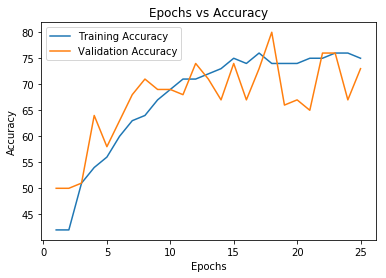

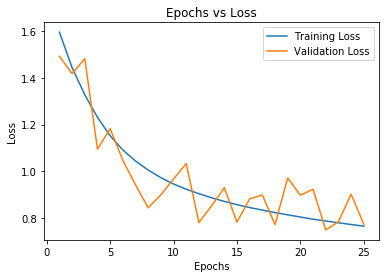

In [80]:
stats_np = np.array(stats_list)
plt.figure()
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,0],label = "Training Accuracy",)
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,1],label = "Validation Accuracy")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Epochs vs Accuracy")
plt.show()

plt.figure()
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,2],label = "Training Loss",)
plt.plot(list(range(1,stats_np.shape[0]+1)),stats_np[:,3],label = "Validation Loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Epochs vs Loss")
plt.show()

In [81]:
CNN

CNNModel(
  (cnn1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (cnn2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=5120, out_features=10, bias=True)
)

In [82]:
torch.save(CNN.state_dict(), 'q1.pth')